In [1]:
import os
import sys
import shutil
import pickle

glp = os.path.abspath("../code")
if not glp in sys.path: sys.path.append( glp )

from global_paths import global_paths

if not global_paths["COBS"] in sys.path: sys.path.append( global_paths["COBS"] )

In [2]:
import cobs
import torch
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from BuildingOccupancy import Person, Meeting, WeeklyMeeting, OneTimeMeeting, BuildingOccupancy
from DefaultBuildings import Building_5ZoneAirCooled
from Agents import agent_constructor
from CentralController import ddpg_episode_mc
import RLCritics
import StateUtilities as SU

In [4]:
no_epochs = 90 + 1
#dirname = '../scripts/checkpoints/011-20210311-2152/' # LReLU, LReLU, Tanh
#dirname = '../scripts/checkpoints/011-20210311-2155/' # Tanh 3x
#dirname = '../scripts/checkpoints/011-20210312-0851/' # Tanh 3x, lr = 0.0005, ab jetzt bias init = constant 0.001
#dirname = '../scripts/checkpoints/011-20210312-0852/' # LReLU, LReLU, Tanh, lr = 0.0005, ab jetzt bias init = constant 0.001
#dirname = '../scripts/checkpoints/011-20210312-0935/' # Tanh 3x, lr = 0.001, --lambda_rwd_mstpc 0.05 (damit der Reward mehr im Intervall [-1,1] liegt)
#dirname = '../scripts/checkpoints/011-20210312-1019/' # wie vorheriges, nur mit reward_ten = -log_10(-reward+1)
dirname = '../checkpoints/SingleAgent_0315/'

In [5]:
epoch_list = [ None for _ in range(no_epochs)]
for fname in os.listdir(dirname):
    if fname == "building_occ.pickle":
        f = open(f"{dirname}/{fname}","rb")
        building_occ = pickle.load(f)
        f.close()
    elif fname.endswith("_output_lists.pickle"):
        epoch_nr = int(fname.split("_")[1])
        if epoch_nr >= no_epochs: continue
        f = open(f"{dirname}/{fname}","rb")
        epoch_list[epoch_nr] = pickle.load(f)
        f.close()

In [6]:
output_lists = {}

timestamp_list = []
for epo in epoch_list:
    timestamp_list.extend( epo["timestamp_list"] )

episode_list = []
for epo in epoch_list:
    episode_list.extend( epo["episode_list"] )

df_indexes = [episode_list, timestamp_list]

In [7]:
for k in epoch_list[0].keys():
    if k in ["timestamp_list", "episode_list"]:
        continue
    output_lists[k] = []
    for epo in epoch_list:
        output_lists[k].extend( epo[k] )

In [8]:
loss_df = pd.DataFrame(output_lists["loss_list"], index = df_indexes)

In [9]:
room_temp = pd.DataFrame(output_lists["room_temp_list"], index = df_indexes)
humidity  = pd.DataFrame(output_lists["humidity_list"],  index = df_indexes)
co2_ppm   = pd.DataFrame(output_lists["co2_ppm_list"],   index = df_indexes)
energy    = pd.DataFrame(output_lists["energy_list"],    index = df_indexes)
outd_temp = pd.DataFrame(output_lists["outd_temp_list"], index = df_indexes)
outd_humi = pd.DataFrame(output_lists["outd_humi_list"], index = df_indexes)
outd_solar_radi = pd.DataFrame(output_lists["outd_solar_radi_list"], index = df_indexes)
outd_wind_speed = pd.DataFrame(output_lists["outd_wspeed_list"],     index = df_indexes)
outd_wind_dir   = pd.DataFrame(output_lists["outd_wdir_list"],       index = df_indexes)
n_manual_stp_ch = pd.DataFrame(output_lists["n_manual_stp_ch_list"], index = df_indexes)
rewards   = pd.DataFrame(output_lists["rewards_list"],   index = df_indexes)

vav_pos   = pd.DataFrame(output_lists["vav_pos_list"],   index = df_indexes)

J_mean    = pd.DataFrame(output_lists["J_mean_list"],    index = df_indexes)
q_st2     = pd.DataFrame(output_lists["q_st2_list"],     index = df_indexes)
cr_frobnorm_mat = pd.DataFrame(output_lists["cr_frobnorm_mat_list"], index = df_indexes)
cr_frobnorm_bia = pd.DataFrame(output_lists["cr_frobnorm_bia_list"], index = df_indexes)
ag_frobnorm_mat = pd.DataFrame(output_lists["ag_frobnorm_mat_list"], index = df_indexes)
ag_frobnorm_bia = pd.DataFrame(output_lists["ag_frobnorm_bia_list"], index = df_indexes)

In [10]:
occupancy_list_abs = [{k: v["absolute number occupants"] for k,v in d.items() } for d in output_lists["occupancy_list"]]
occupancy_list_rel = [{k: v["relative number occupants"] for k,v in d.items() } for d in output_lists["occupancy_list"]]
occupancy_list_meanT = [{k: v["mean comfort temp"] for k,v in d.items() } for d in output_lists["occupancy_list"]]

In [11]:
occupancy_absolute = pd.DataFrame(occupancy_list_abs, index = df_indexes)
occupancy_relative = pd.DataFrame(occupancy_list_rel, index = df_indexes)
occupancy_meantemp = pd.DataFrame(occupancy_list_meanT, index = df_indexes)

In [22]:
def plot_twice(plot_df, cols, title, range_start = None, range_end = None):
    _, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,6))
    if not range_start is None and not range_end is None:
        plot_df = plot_df.loc[range_start:range_end]
    elif not range_start is None:
        plot_df = plot_df.loc[range_start:]
    elif not range_end is None:
        plot_df = plot_df.loc[:range_end]
    plot_df_descr = plot_df.groupby(level=0).describe()
    plot_df_descr.columns = [ i[1] for i in plot_df_descr.columns ]
    plot_df_descr[ cols ].plot(title=title, ax=axes[0])
    plot_df.plot(title=title, ax=axes[1])

In [24]:
range_start = 10
range_end   = None

<AxesSubplot:title={'center':'Loss'}>

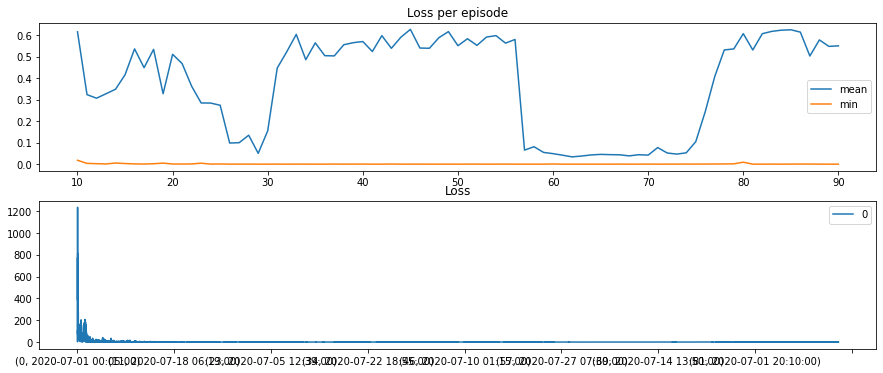

In [21]:
_, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,6))
loss_df_g = loss_df.loc[10:].groupby(level=0).describe()
loss_df_g.columns = [ i[1] for i in loss_df_g.columns ]
loss_df_g[["mean", "min"]].plot(title="Loss per episode", ax=axes[0])
loss_df.plot(title="Loss", ax=axes[1])

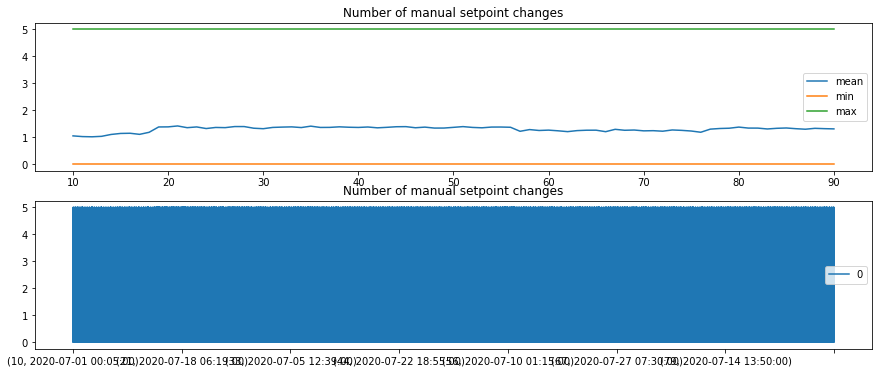

In [25]:
plot_twice(n_manual_stp_ch, ["mean", "min", "max"], "Number of manual setpoint changes", range_start, range_end)

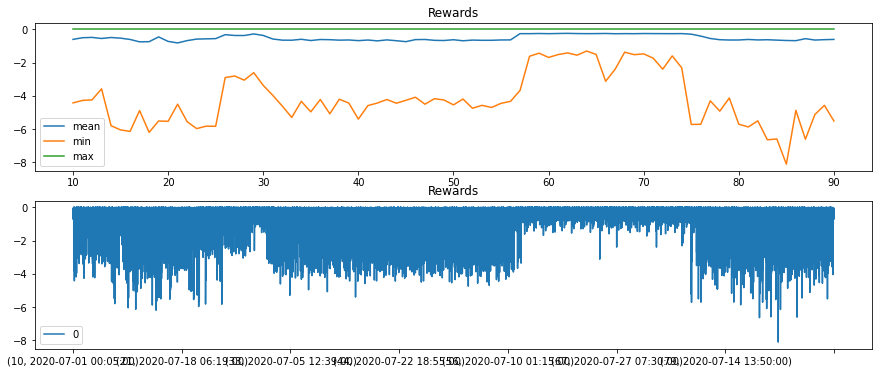

In [26]:
plot_twice(rewards, ["mean", "min", "max"], "Rewards", range_start, range_end)

<AxesSubplot:>

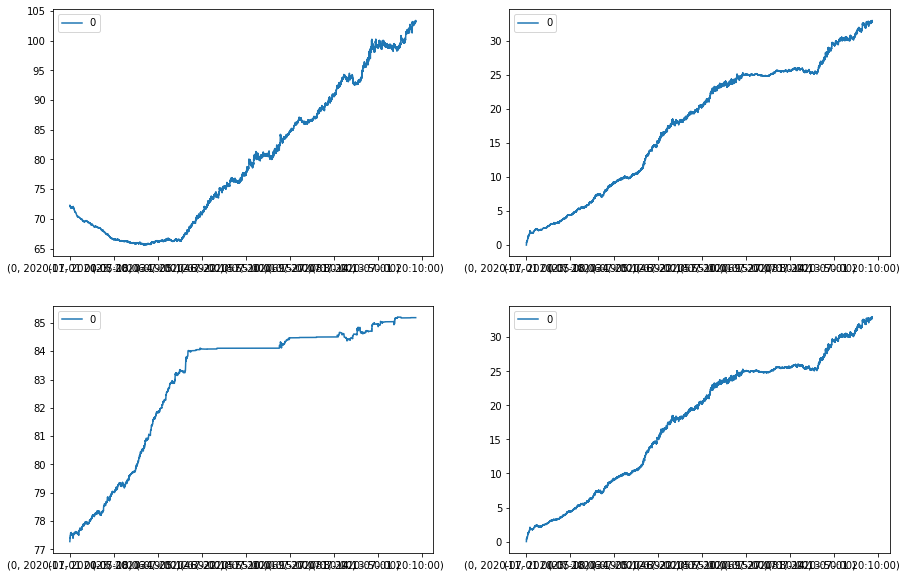

In [16]:
_, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
cr_frobnorm_mat.plot(ax=axes[0,0])
cr_frobnorm_bia.plot(ax=axes[0,1])
ag_frobnorm_mat.plot(ax=axes[1,0])
cr_frobnorm_bia.plot(ax=axes[1,1])

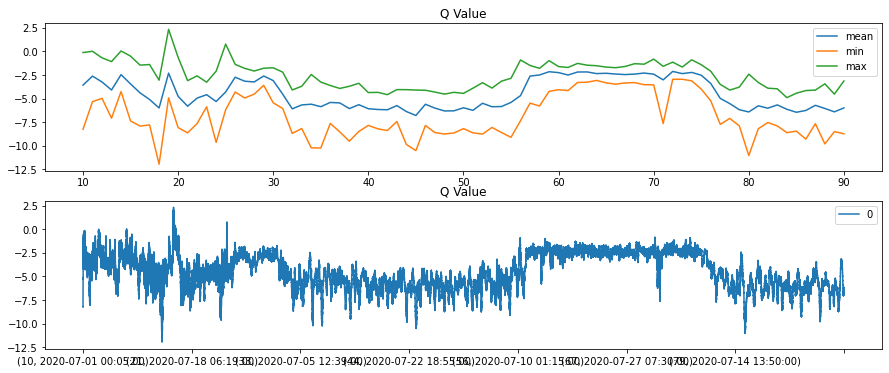

In [27]:
#_, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
#J_mean.plot(ax=axes[0])
#q_st2.plot(ax=axes[1])
plot_twice(q_st2.loc[10:], ["mean", "min", "max"], "Q Value", range_start, range_end)

Details: Temperatur Setpoints

In [28]:
selected_episode = 80